<a href="https://colab.research.google.com/github/Nazneen-akram/Datasets-for-Recommender-Systems/blob/master/Assignment_2_CV_Classification_using_Pizza_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import os, pathlib
import numpy as np
import time
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D


import matplotlib.pyplot as plt
import seaborn as sns

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

-- from Kaggle

In [2]:
from google.colab import files
files.upload()    # you will chose file for your kaggle.json, downloaded from laggle/settings

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazneenakram","key":"08d579900181a0e53c4bac39e23b069d"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d carlosrunner/pizza-not-pizza

 99% 100M/101M [00:07<00:00, 19.6MB/s] 
100% 101M/101M [00:07<00:00, 14.4MB/s]


The Data Extraction

In [5]:
!unzip pizza-not-pizza.zip && rm -rf pizza-not-pizza.zip

Archive:  pizza-not-pizza.zip
  inflating: pizza_not_pizza/food101_subset.py  
  inflating: pizza_not_pizza/not_pizza/1005746.jpg  
  inflating: pizza_not_pizza/not_pizza/1009225.jpg  
  inflating: pizza_not_pizza/not_pizza/1012312.jpg  
  inflating: pizza_not_pizza/not_pizza/1018802.jpg  
  inflating: pizza_not_pizza/not_pizza/1020735.jpg  
  inflating: pizza_not_pizza/not_pizza/1027142.jpg  
  inflating: pizza_not_pizza/not_pizza/102839.jpg  
  inflating: pizza_not_pizza/not_pizza/1043233.jpg  
  inflating: pizza_not_pizza/not_pizza/1045400.jpg  
  inflating: pizza_not_pizza/not_pizza/104773.jpg  
  inflating: pizza_not_pizza/not_pizza/1050956.jpg  
  inflating: pizza_not_pizza/not_pizza/1054362.jpg  
  inflating: pizza_not_pizza/not_pizza/1062097.jpg  
  inflating: pizza_not_pizza/not_pizza/1066151.jpg  
  inflating: pizza_not_pizza/not_pizza/1070772.jpg  
  inflating: pizza_not_pizza/not_pizza/1070867.jpg  
  inflating: pizza_not_pizza/not_pizza/107499.jpg  
  inflating: pizza_not_

**Copying images to training, validation, and test directories**

In [6]:
# Define the directories
data_dir = pathlib.Path('pizza_not_pizza')
pizza_dir = data_dir / 'pizza'
not_pizza_dir = data_dir / 'not_pizza'

In [7]:
class_names = []
for f in data_dir.rglob('*'):
  if f.is_dir():
    class_names.append(str(f).rsplit('/')[-1])

class_names

['not_pizza', 'pizza']

In [8]:
# Count the number of files (i.e., images) in each directory
pizza_count = len(list(pizza_dir.glob('*')))
not_pizza_count = len(list(not_pizza_dir.glob('*')))

print(f"There are {pizza_count} pizza images and {not_pizza_count} not pizza images.")

There are 983 pizza images and 983 not pizza images.


### Data preprocessing

In [9]:
# Defining data generator without Data Augmentation. Normalize the pixel values of input images,
data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_ds = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary'
                                          )
valid_ds = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary'
                                        )

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


### Data Visualisation

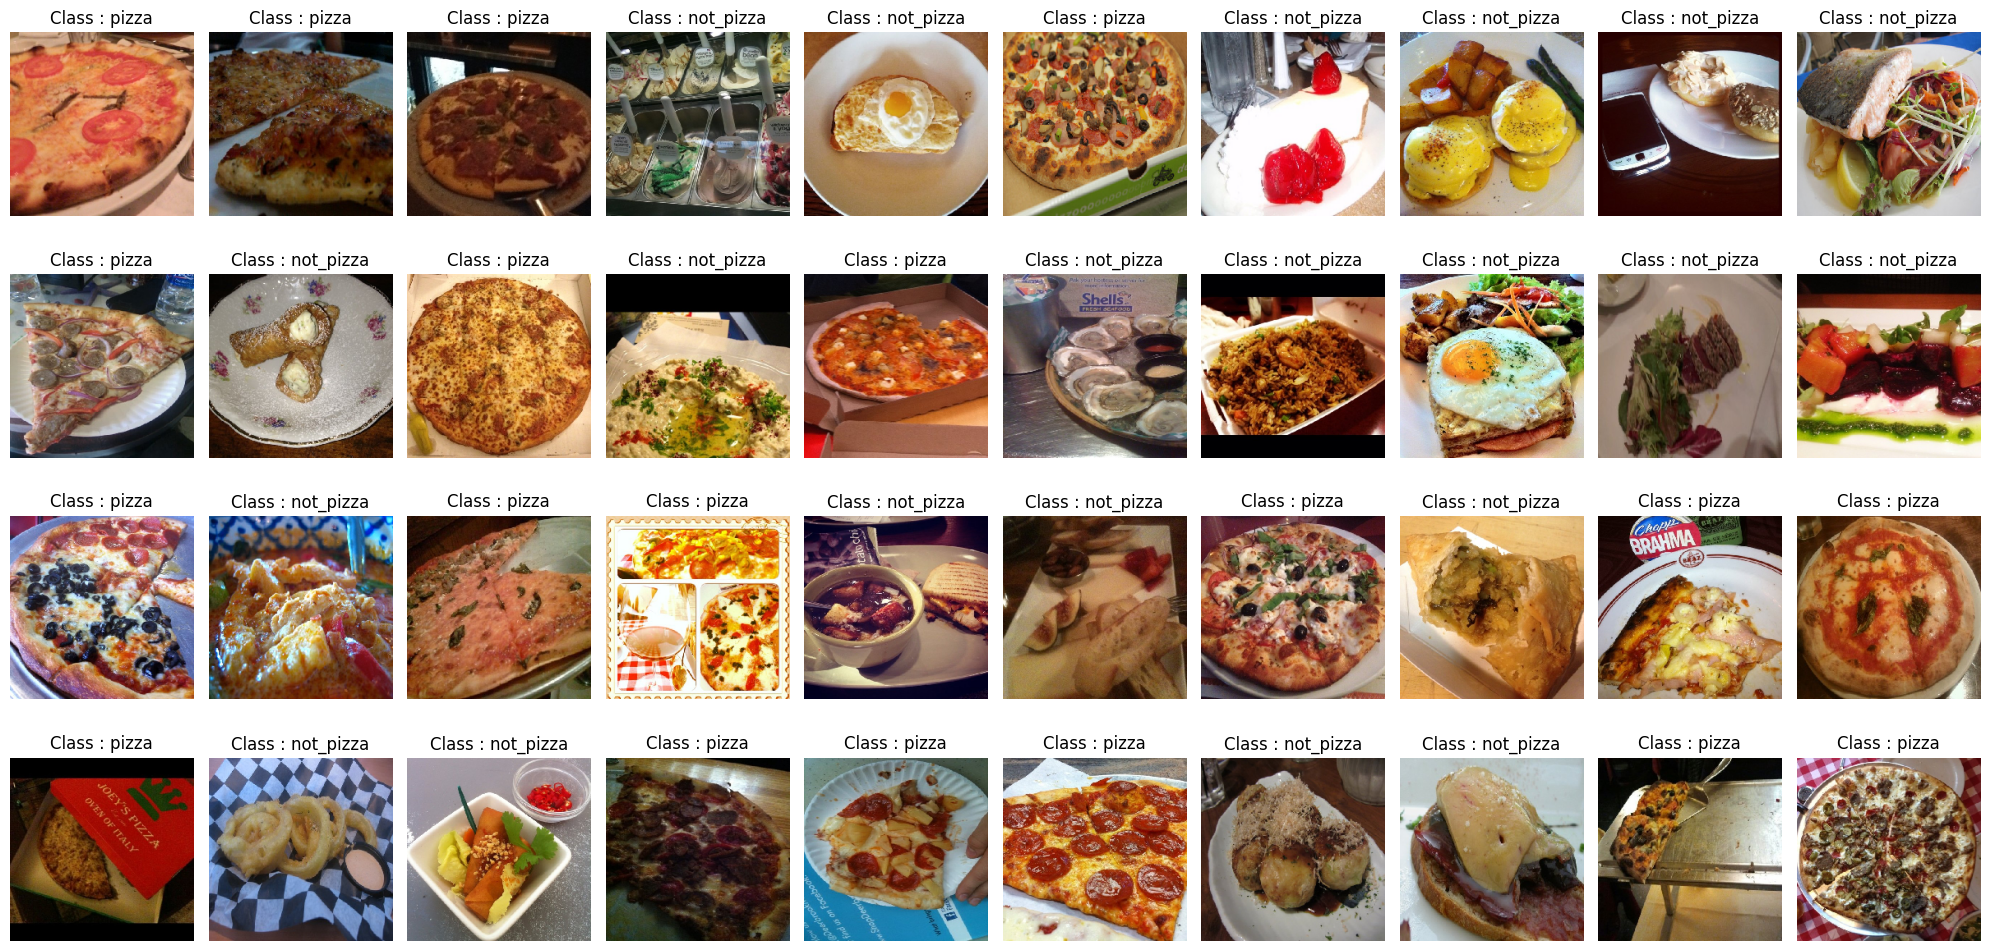

In [10]:
i=1
plt.figure(figsize=(20,10))
for images, labels in train_ds:

    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])

    plt.subplot(4,10,i)
    plt.imshow(image)
    plt.title(f"Class : {class_names[label]}")
    plt.axis('off')

    i+=1
    if i>=41:
        break
plt.tight_layout()
plt.show()

### Building the model (Simple CNN)

**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [11]:
for data_batch, labels_batch in train_ds:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


**Instantiating a small convnet for pizza vs. not pizza classification**

In [12]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer. 224x224 pixels and 3 color channels (typically representing Red, Green, and Blue)
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer
])

In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      4128      
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 1)                 1577089   
                                                                 
Total params: 1581633 (6.03 MB)
Trainable params: 1581633 (6.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Configuring the model for training**

In [15]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

**Fitting the model using a `Dataset`**

In [16]:
# Start time
start_time_history_1 = time.time()

history_1 = model_1.fit(train_ds,
                        epochs= 5,
                        steps_per_epoch = len(train_ds),
                        validation_data = valid_ds,
                        validation_steps = len(valid_ds))

# End time
end_time_history_1 = time.time()

Epoch 1/5
50/50 [==============================] - 20s 127ms/step - loss: 1.3222 - accuracy: 0.6372 - val_loss: 0.6013 - val_accuracy: 0.6760
Epoch 2/5
50/50 [==============================] - 7s 135ms/step - loss: 0.4364 - accuracy: 0.8107 - val_loss: 0.5787 - val_accuracy: 0.7117
Epoch 3/5
50/50 [==============================] - 6s 120ms/step - loss: 0.2349 - accuracy: 0.9282 - val_loss: 0.6146 - val_accuracy: 0.6964
Epoch 4/5
50/50 [==============================] - 7s 135ms/step - loss: 0.0877 - accuracy: 0.9860 - val_loss: 0.5779 - val_accuracy: 0.7321
Epoch 5/5
50/50 [==============================] - 7s 135ms/step - loss: 0.0406 - accuracy: 0.9943 - val_loss: 0.7766 - val_accuracy: 0.6888


In [121]:
# Display the number of trainable parameters in a variable
train_param_model_1 = model_1.count_params()

print(f'The number of trainable parameters in Model 1 is: {train_param_model_1}')

# Calculate the training time
train_time_1 = end_time_history_1 - start_time_history_1

print(f'The training time of the Model 1 is: {train_time_1:.2f} seconds')

The number of trainable parameters in Model 1 is: 1581633
The training time of the Model 1 is: 53.74 seconds


**Displaying curves of loss and accuracy during training**

In [19]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

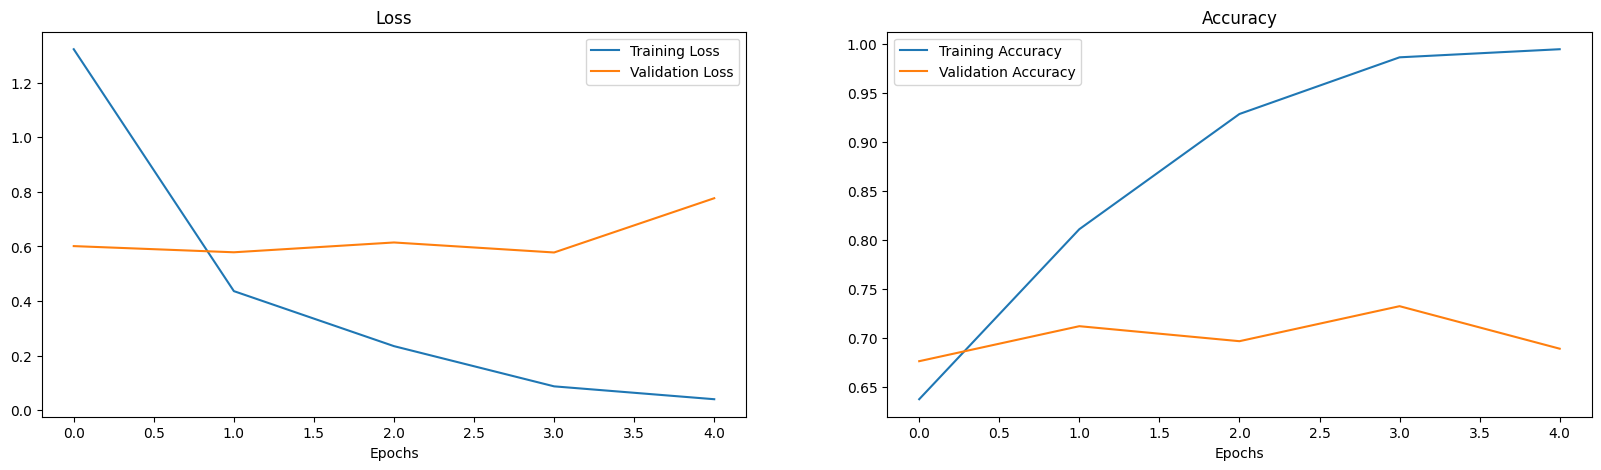

In [20]:
plot_loss_curves(history_1)

In [21]:
model_1.save('convnet_from_scratch.keras')

In [22]:
from keras.saving import load_model

test_model = load_model('convnet_from_scratch.keras')

**Evaluating the model on the test set**

In [123]:
test_loss_model_1, test_acc_1 = test_model.evaluate(valid_ds)
print(f"Test accuracy: {test_acc_1:.3f}")

13/13 [==============================] - 1s 81ms/step - loss: 0.7766 - accuracy: 0.6888
Test accuracy: 0.689


### 2. Simple CNN with data augmentation

**Define a data augmentation stage to add to an image model**

In [24]:
# Defining data generator with Data Augmentation
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
   ])

**Displaying some randomly augmented training images**

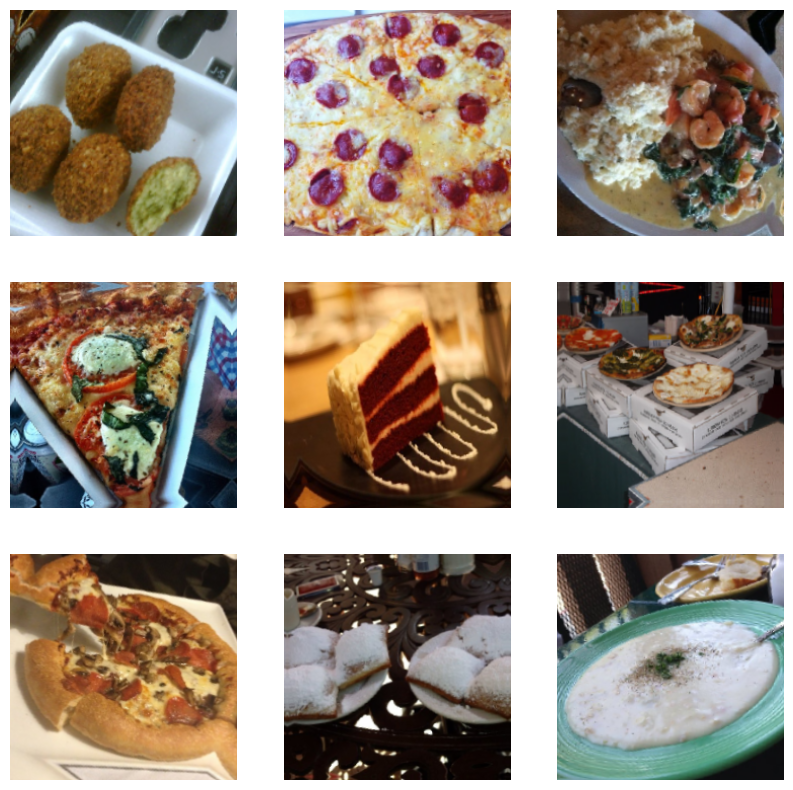

In [25]:
plt.figure(figsize=(10, 10))
images, _ = next(train_ds)
for i in range(9):
  # Apply data augmentation
  augmented_images = data_augmentation(images[i][None, ...])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.axis("off")

**Displaying count of Augmented training images**

In [27]:
data_gen_augmented = ImageDataGenerator(rescale = 1/255.,
                                        validation_split = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 32,
                                                              subset = 'training',
                                                              class_mode = 'binary')

print('Unchanged Validation Images:')
val_data = data_gen_augmented.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 1574 images belonging to 2 classes.
Unchanged Validation Images:
Found 392 images belonging to 2 classes.


**Defining a new convnet that includes image augmentation**

In [28]:
# Start time
start_time_history_2 = time.time()

history_2 = model_1.fit(train_data_augmented, # changing the training data
                        epochs= 10,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = val_data,
                        validation_steps = len(val_data))

# End time
end_time_history_2 = time.time()

Epoch 1/10
50/50 [==============================] - 29s 583ms/step - loss: 0.6713 - accuracy: 0.6620 - val_loss: 0.6468 - val_accuracy: 0.6607
Epoch 2/10
50/50 [==============================] - 29s 573ms/step - loss: 0.6100 - accuracy: 0.6874 - val_loss: 0.5866 - val_accuracy: 0.7092
Epoch 3/10
50/50 [==============================] - 35s 703ms/step - loss: 0.5760 - accuracy: 0.6995 - val_loss: 0.5287 - val_accuracy: 0.7423
Epoch 4/10
50/50 [==============================] - 29s 576ms/step - loss: 0.5971 - accuracy: 0.6995 - val_loss: 0.5244 - val_accuracy: 0.7832
Epoch 5/10
50/50 [==============================] - 35s 698ms/step - loss: 0.5621 - accuracy: 0.7217 - val_loss: 0.5079 - val_accuracy: 0.7628
Epoch 6/10
50/50 [==============================] - 29s 576ms/step - loss: 0.5238 - accuracy: 0.7459 - val_loss: 0.6057 - val_accuracy: 0.6964
Epoch 7/10
50/50 [==============================] - 28s 571ms/step - loss: 0.5536 - accuracy: 0.7243 - val_loss: 0.6229 - val_accuracy: 0.6531

In [114]:
# Calculate the training time
train_time_2 =  end_time_history_2 - start_time_history_2
print(f'The training time of the model is: {train_time_2:.2f} seconds')

#Trainable Parameters
train_param_model_2=train_param_model_1
print(f'The number of trainable parameters in Model 2 is: {train_param_model_1}')

#Model Accuracy with Data Augmentation
test_loss_2, test_acc_2 = model_1.evaluate(val_data)
print(f"Test accuracy: {test_acc_2:.3f}")

The training time of the model is: 350.92 seconds
The number of trainable parameters in Model 2 is: 1581633
13/13 [==============================] - 5s 402ms/step - loss: 0.5266 - accuracy: 0.7526
Test accuracy: 0.753


## Leveraging a pretrained model

### Pretrained with feature extraction (with as is data)

**Instantiating the Pretrained model VGG16 convolutional base**

In [57]:
conv_base = keras.applications.vgg16.VGG16(
                  weights='imagenet',
                  include_top=False, #only includes the convolutional layers and not the fully connected layers to extract features
                  input_shape=(224, 224, 3))

# Make the layers non-trainable
conv_base.trainable = False

model_3 = Sequential([
    conv_base,
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [58]:
# Start time
start_time_history_3 = time.time()

history_3 = model_3.fit(train_ds,
                        epochs= 5,
                        steps_per_epoch = len(train_ds),
                        validation_data = valid_ds,
                        validation_steps = len(valid_ds))

# End time
end_time_history_3 = time.time()

Epoch 1/5
50/50 [==============================] - 10s 188ms/step - loss: 0.4551 - accuracy: 0.7719 - val_loss: 0.3160 - val_accuracy: 0.8750
Epoch 2/5
50/50 [==============================] - 8s 167ms/step - loss: 0.2044 - accuracy: 0.9193 - val_loss: 0.2353 - val_accuracy: 0.9209
Epoch 3/5
50/50 [==============================] - 9s 172ms/step - loss: 0.1381 - accuracy: 0.9670 - val_loss: 0.2281 - val_accuracy: 0.9337
Epoch 4/5
50/50 [==============================] - 8s 172ms/step - loss: 0.1025 - accuracy: 0.9809 - val_loss: 0.2449 - val_accuracy: 0.8980
Epoch 5/5
50/50 [==============================] - 10s 193ms/step - loss: 0.0752 - accuracy: 0.9886 - val_loss: 0.2995 - val_accuracy: 0.8699


In [61]:
# Store the number of trainable parameters in a variable
train_param_model_3 = model_3.count_params()

print(f'The number of trainable parameters in Pretrained model is: {train_param_model_3}')

#Train Time for Model 4
train_time_3 = end_time_history_3 - start_time_history_3
print(f'The training time of the model is: {train_time_3:.2f} seconds')

#model Accuracy
test_loss_3, test_acc_3 = model_3.evaluate(valid_ds)
print(f"Test accuracy: {test_acc_3:.3f}")

The number of trainable parameters in Pretrained model is: 14739777
The training time of the model is: 47.89 seconds
13/13 [==============================] - 2s 119ms/step - loss: 0.2995 - accuracy: 0.8699
Test accuracy: 0.870


### Pretrained with feature extraction (with data augmentation)

In [63]:
start_time_history_4 = time.time()
history_4 = model_3.fit(train_data_augmented,
                        epochs= 10,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = val_data,
                        validation_steps = len(val_data)
                        )

# End time
end_time_history_4 = time.time()

Epoch 1/10
50/50 [==============================] - 34s 672ms/step - loss: 0.3459 - accuracy: 0.8621 - val_loss: 0.6770 - val_accuracy: 0.7270
Epoch 2/10
50/50 [==============================] - 32s 651ms/step - loss: 0.4452 - accuracy: 0.8164 - val_loss: 0.3722 - val_accuracy: 0.8418
Epoch 3/10
50/50 [==============================] - 32s 634ms/step - loss: 0.3034 - accuracy: 0.8755 - val_loss: 0.2666 - val_accuracy: 0.8954
Epoch 4/10
50/50 [==============================] - 39s 792ms/step - loss: 0.2680 - accuracy: 0.8875 - val_loss: 0.4465 - val_accuracy: 0.8418
Epoch 5/10
50/50 [==============================] - 45s 903ms/step - loss: 0.2932 - accuracy: 0.8844 - val_loss: 0.3419 - val_accuracy: 0.8444
Epoch 6/10
50/50 [==============================] - 34s 676ms/step - loss: 0.2412 - accuracy: 0.8996 - val_loss: 0.2615 - val_accuracy: 0.8929
Epoch 7/10
50/50 [==============================] - 37s 743ms/step - loss: 0.2134 - accuracy: 0.9072 - val_loss: 0.2382 - val_accuracy: 0.9107

In [115]:
# Calculate the training time
train_time_4 =  end_time_history_4 - start_time_history_4

print(f'The training time of the model is: {train_time_4:.2f} seconds')

train_param_model_4=train_param_model_3
print(f'The number of trainable parameters in Pretrained model is: {train_param_model_3}')

#model Accuracy
test_loss_4, test_acc_4 = model_3.evaluate(val_data)
print(f"Test accuracy: {test_acc_4:.3f}")

The training time of the model is: 410.20 seconds
The number of trainable parameters in Pretrained model is: 14739777
13/13 [==============================] - 7s 491ms/step - loss: 0.2769 - accuracy: 0.8878
Test accuracy: 0.888


**Plotting the results**

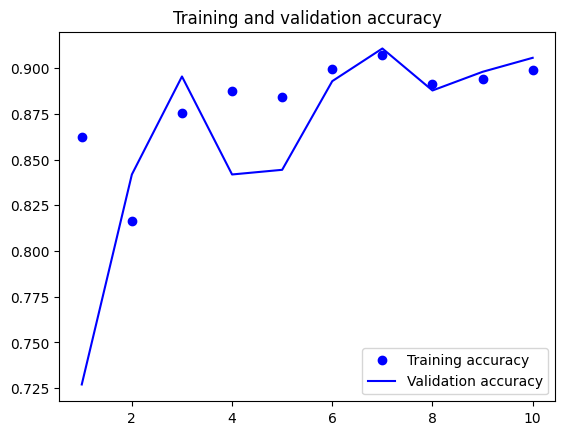

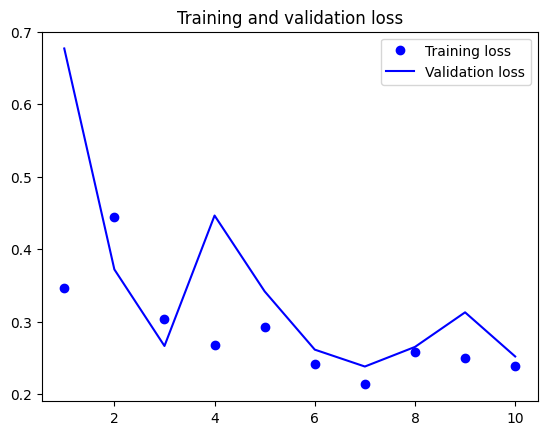

In [113]:
import matplotlib.pyplot as plt
acc = history_4.history["accuracy"]
val_acc = history_4.history["val_accuracy"]
loss = history_4.history["loss"]
val_loss = history_4.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Fine-tuning a pretrained model

**Instantiating and freezing the EfficientNet convolutional base**

In [101]:
conv_base_2  = keras.applications.efficientnet.EfficientNetB7(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
    )

conv_base_2.trainable = False

**Printing the list of trainable weights before and after freezing**

In [103]:
conv_base_2.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base_2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 709


In [104]:
conv_base_2.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base_2.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Unfreeze the last 5 layers for fine-tuning**

In [105]:
conv_base_2.trainable = True
for layer in conv_base_2.layers[:-5]:
    layer.trainable = False

**Fine-tuning the model (with as is data)**

In [106]:
model_5 = Sequential([
    conv_base_2,
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_5.compile(loss = 'binary_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

In [107]:
# Start time
start_time_history_5 = time.time()

history_5 = model_5.fit(train_ds,
                        epochs= 20,
                        steps_per_epoch = len(train_ds),
                        validation_data = valid_ds,
                        validation_steps = len(valid_ds))

# End time
end_time_history_5 = time.time()

Epoch 1/20
50/50 [==============================] - 53s 568ms/step - loss: 0.7743 - accuracy: 0.5013 - val_loss: 0.7085 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 24s 474ms/step - loss: 0.8581 - accuracy: 0.4949 - val_loss: 0.7012 - val_accuracy: 0.5000
Epoch 3/20
50/50 [==============================] - 23s 455ms/step - loss: 0.7163 - accuracy: 0.5146 - val_loss: 0.7915 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 23s 453ms/step - loss: 0.7272 - accuracy: 0.5127 - val_loss: 0.6936 - val_accuracy: 0.5026
Epoch 5/20
50/50 [==============================] - 23s 465ms/step - loss: 0.7564 - accuracy: 0.5127 - val_loss: 0.7041 - val_accuracy: 0.4949
Epoch 6/20
50/50 [==============================] - 24s 470ms/step - loss: 0.7694 - accuracy: 0.5102 - val_loss: 0.8524 - val_accuracy: 0.5000
Epoch 7/20
50/50 [==============================] - 23s 466ms/step - loss: 0.7740 - accuracy: 0.5152 - val_loss: 0.7336 - val_accuracy: 0.5051

In [116]:
# Calculate the training time
train_time_5 =  end_time_history_5 - start_time_history_5

print(f'The training time of the model is: {train_time_5:.2f} seconds')

train_param_model_5 = conv_base_2.count_params()
print(f'The number of trainable parameters in Pretrained model is: {conv_base_2.count_params()}')

#model Accuracy
test_loss_5, test_acc_5 = model_5.evaluate(valid_ds)
print(f"Test accuracy: {test_acc_5:.3f}")

The training time of the model is: 583.35 seconds
The number of trainable parameters in Pretrained model is: 64097687
13/13 [==============================] - 5s 332ms/step - loss: 0.6878 - accuracy: 0.5510
Test accuracy: 0.551


**Pretrained with last 5 layers Fine tuning, (with data augmentation)**

In [110]:
# Start time
start_time_history_6 = time.time()

history_6 = model_5.fit(train_data_augmented,
                        epochs= 20,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = val_data,
                        validation_steps = len(val_data))

# End time
end_time_history_6 = time.time()

Epoch 1/20
50/50 [==============================] - 42s 845ms/step - loss: 0.7736 - accuracy: 0.5286 - val_loss: 0.6843 - val_accuracy: 0.5255
Epoch 2/20
50/50 [==============================] - 38s 760ms/step - loss: 0.7127 - accuracy: 0.5540 - val_loss: 0.7170 - val_accuracy: 0.4974
Epoch 3/20
50/50 [==============================] - 38s 752ms/step - loss: 0.8020 - accuracy: 0.5197 - val_loss: 1.1452 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 38s 750ms/step - loss: 0.8200 - accuracy: 0.5140 - val_loss: 0.6880 - val_accuracy: 0.5510
Epoch 5/20
50/50 [==============================] - 38s 752ms/step - loss: 0.7326 - accuracy: 0.5191 - val_loss: 0.6891 - val_accuracy: 0.5128
Epoch 6/20
50/50 [==============================] - 38s 759ms/step - loss: 0.7451 - accuracy: 0.5184 - val_loss: 0.6828 - val_accuracy: 0.5561
Epoch 7/20
50/50 [==============================] - 37s 748ms/step - loss: 0.7363 - accuracy: 0.5006 - val_loss: 0.9286 - val_accuracy: 0.5000

In [117]:
# Calculate the training time
train_time_6 =  end_time_history_6 - start_time_history_6

print(f'The training time of the model is: {train_time_6:.2f} seconds')

train_param_model_6=model_5.count_params()
print(f'The number of trainable parameters in Pretrained model is: {train_param_model_6}')

#model Accuracy
test_loss_6, test_acc_6 = model_5.evaluate(val_data)
print(f"Test accuracy: {test_acc_6:.3f}")

The training time of the model is: 825.74 seconds
The number of trainable parameters in Pretrained model is: 64223128
13/13 [==============================] - 7s 528ms/step - loss: 0.6908 - accuracy: 0.5204
Test accuracy: 0.520


## Summary

In [124]:
# Define the data
data = {
    'Model': ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'],
    'Train Time': [train_time_1, train_time_2, train_time_3, train_time_4, train_time_5, train_time_6],
    'Train Parameters': [train_param_model_1, train_param_model_2, train_param_model_3, train_param_model_4, train_param_model_5, train_param_model_6],
    'Test Accuracy': [test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5, test_acc_6]
}

# Create the dataframe
df = pd.DataFrame(data)

# Print the dataframe
df


Model  Train Time  Train Parameters  Test Accuracy
0  Model 1   53.742681           1581633       0.688776
1  Model 2  350.916625           1581633       0.752551
2  Model 3   47.892080          14739777       0.869898
3  Model 4  410.201595          14739777       0.887755
4  Model 5  583.347745          64097687       0.551020
5  Model 6  825.741132          64223128       0.520408